
# Spark — Clickstream e-commerce desde CSV (sin UDF) → Gráficos

**Objetivo:** Cargar un CSV de *clickstream*, normalizar URLs y clasificar dispositivo usando **funciones nativas de Spark** (sin UDFs), calcular **embudo por dispositivo**, y mostrar **gráficos** (sin escribir archivos).



## 0) (Windows) Usar el mismo Python para driver y ejecutores
Ejecuta esta celda **antes** de crear la `SparkSession` si usas Windows.


In [1]:

import os, sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
print("PYSPARK_PYTHON =", os.environ.get("PYSPARK_PYTHON"))
print("PYSPARK_DRIVER_PYTHON =", os.environ.get("PYSPARK_DRIVER_PYTHON"))


PYSPARK_PYTHON = c:\Users\patri\AppData\Local\Programs\Python\Python310\python.exe
PYSPARK_DRIVER_PYTHON = c:\Users\patri\AppData\Local\Programs\Python\Python310\python.exe


## 1) Crear SparkSession

In [2]:

from pyspark.sql import SparkSession

spark = (SparkSession.builder
         .appName("Clickstream_NoUDF_Graficos_FINAL")
         .config("spark.python.use.daemon","false")  # más estable en Windows
         .getOrCreate())

spark


## 2) Cargar CSV de clickstream

In [3]:

# Ajusta esta ruta si tu archivo está en otra carpeta
# Si ya descargaste 'clickstream.csv' generado antes, puedes usarlo directamente.
input_path = "clickstream.csv"

df_raw = (spark.read
          .option("header", True)
          .option("inferSchema", True)
          .option("multiLine", True)
          .option("escape", '"')
          .csv(input_path))

df_raw.printSchema()
df_raw.show(5, truncate=False)
print("Filas:", df_raw.count())


root
 |-- event_time: timestamp (nullable = true)
 |-- user_id: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- page_url: string (nullable = true)
 |-- referrer_url: string (nullable = true)
 |-- action: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_agent: string (nullable = true)

+-------------------+-------+----------+-----------------------+--------------------------------------+--------+----------+------+--------------------------------------------------------------------+
|event_time         |user_id|session_id|page_url               |referrer_url                          |action  |product_id|price |user_agent                                                          |
+-------------------+-------+----------+-----------------------+--------------------------------------+--------+----------+------+--------------------------------------------------------------------+
|2025-08-29 10:30:19|u039

## 3) Transformaciones sin UDFs: `page_canonical` + `device`

In [4]:

from pyspark.sql.functions import to_timestamp, col, lower, trim, regexp_replace, when

# Canonicalizar URL sin UDF:
# - minúsculas
# - quitar query params
# - quitar barra final (si no es raíz)
page_no_query = regexp_replace(lower(trim(col("page_url"))), r"\?.*$", "")
page_canonical = regexp_replace(page_no_query, r"/$", "")

df = (df_raw
      .withColumn("event_time", to_timestamp(col("event_time")))
      .withColumn("page_canonical", page_canonical)
     )

# Clasificar dispositivo sin UDF (heurística básica):
ua = lower(col("user_agent"))
df = df.withColumn(
    "device",
    when(ua.contains("mobile") | ua.contains("iphone") | ua.contains("android") | ua.contains("ipad"), "mobile")
    .otherwise("desktop")
)

df.select("event_time","session_id","page_url","page_canonical","device","action")   .show(8, truncate=False)


+-------------------+----------+---------------------------------+-----------------+-------+-----------+
|event_time         |session_id|page_url                         |page_canonical   |device |action     |
+-------------------+----------+---------------------------------+-----------------+-------+-----------+
|2025-08-29 10:30:19|s005679   |/checkout                        |/checkout        |mobile |checkout   |
|2025-08-28 16:17:51|s001421   |/search?utm=email&q=29           |/search          |desktop|view       |
|2025-08-29 18:17:17|s025523   |/category/home                   |/category/home   |desktop|view       |
|2025-08-29 16:14:17|s011616   |/checkout                        |/checkout        |mobile |view       |
|2025-08-27 13:25:54|s001062   |/search?utm=email&q=472          |/search          |mobile |view       |
|2025-08-28 17:03:38|s005770   |/category/fashion?utm=seo&q=776  |/category/fashion|mobile |view       |
|2025-08-29 16:51:25|s000933   |/category/fashion?utm=e

## 4) Embudo por dispositivo (view → add_to_cart → checkout → purchase)

In [5]:

from pyspark.sql.functions import when, max as Fmax, sum as Fsum, round as Fround

flags = (df.select("session_id","device","action")
           .withColumn("is_view",       when(col("action")=="view", 1).otherwise(0))
           .withColumn("is_add",        when(col("action")=="add_to_cart", 1).otherwise(0))
           .withColumn("is_checkout",   when(col("action")=="checkout", 1).otherwise(0))
           .withColumn("is_purchase",   when(col("action")=="purchase", 1).otherwise(0))
           .groupBy("session_id","device")
           .agg(Fmax("is_view").alias("has_view"),
                Fmax("is_add").alias("has_add"),
                Fmax("is_checkout").alias("has_checkout"),
                Fmax("is_purchase").alias("has_purchase"))
        )

funnel = (flags.groupBy("device")
               .agg(Fsum("has_view").alias("sessions_with_view"),
                    Fsum("has_add").alias("sessions_with_add"),
                    Fsum("has_checkout").alias("sessions_with_checkout"),
                    Fsum("has_purchase").alias("sessions_with_purchase"))
          )

funnel = (funnel
          .withColumn("add_rate",       Fround(col("sessions_with_add")       / col("sessions_with_view"), 4))
          .withColumn("checkout_rate",  Fround(col("sessions_with_checkout")  / col("sessions_with_view"), 4))
          .withColumn("purchase_rate",  Fround(col("sessions_with_purchase")  / col("sessions_with_view"), 4))
          .orderBy("device"))

funnel.show(truncate=False)


+-------+------------------+-----------------+----------------------+----------------------+--------+-------------+-------------+
|device |sessions_with_view|sessions_with_add|sessions_with_checkout|sessions_with_purchase|add_rate|checkout_rate|purchase_rate|
+-------+------------------+-----------------+----------------------+----------------------+--------+-------------+-------------+
|desktop|4370              |1197             |842                   |1176                  |0.2739  |0.1927       |0.2691       |
|mobile |6232              |1791             |1291                  |1766                  |0.2874  |0.2072       |0.2834       |
+-------+------------------+-----------------+----------------------+----------------------+--------+-------------+-------------+



## 5) Top productos por revenue y top páginas por vistas

In [6]:

from pyspark.sql.functions import sum as Fsum, desc

purchases = df.filter(col("action")=="purchase")

top_products = (purchases
                .groupBy("product_id")
                .agg(Fsum("price").alias("revenue"))
                .orderBy(desc("revenue"))
                .limit(10))

top_pages = (df.filter(col("action")=="view")
               .groupBy("page_canonical")
               .agg(Fsum(when(col("action")=="view",1).otherwise(0)).alias("views"))
               .orderBy(desc("views"))
               .limit(10))

top_products.show(truncate=False)
top_pages.show(truncate=False)


+----------+------------------+
|product_id|revenue           |
+----------+------------------+
|sku00064  |3737.26           |
|sku00404  |3444.5099999999998|
|sku00387  |3431.08           |
|sku00078  |3398.2700000000004|
|sku00089  |3263.0900000000006|
|sku00475  |3199.15           |
|sku00235  |3191.8400000000006|
|sku00374  |3137.2599999999998|
|sku00053  |3134.5800000000004|
|sku00103  |3115.38           |
+----------+------------------+

+---------------------+-----+
|page_canonical       |views|
+---------------------+-----+
|/category/sports     |1738 |
|/home                |1706 |
|/category/electronics|1691 |
|/category/fashion    |1660 |
|/search              |1651 |
|/category/home       |1634 |
|/product             |1236 |
|/cart                |313  |
|/checkout            |102  |
|/thankyou            |22   |
+---------------------+-----+



## 6) Gráficos (Matplotlib)

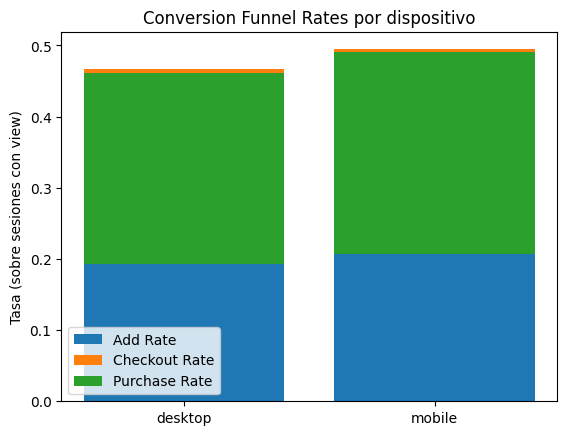

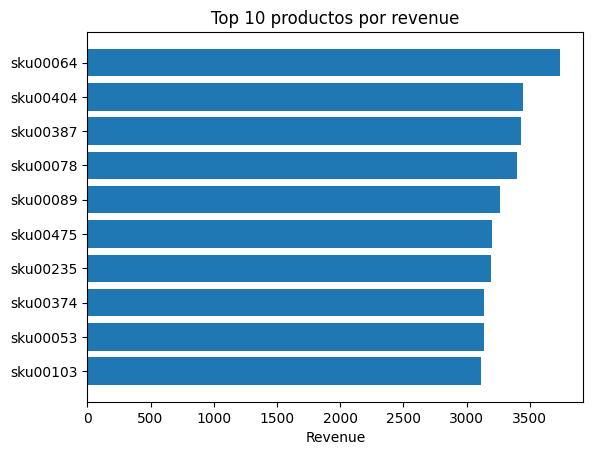

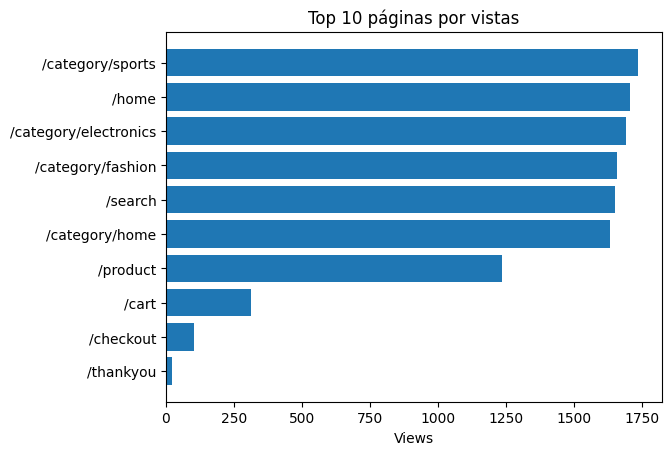

In [7]:

import matplotlib.pyplot as plt

# 6.1 Funnel por dispositivo
pdf_funnel = funnel.toPandas()

plt.figure()
plt.bar(pdf_funnel["device"], pdf_funnel["add_rate"], label="Add Rate")
plt.bar(pdf_funnel["device"], pdf_funnel["checkout_rate"], bottom=pdf_funnel["add_rate"], label="Checkout Rate")
plt.bar(pdf_funnel["device"], pdf_funnel["purchase_rate"], bottom=pdf_funnel["checkout_rate"], label="Purchase Rate")
plt.title("Conversion Funnel Rates por dispositivo")
plt.ylabel("Tasa (sobre sesiones con view)")
plt.legend()
plt.show()

# 6.2 Top productos por revenue
pdf_products = top_products.toPandas()
plt.figure()
plt.barh(pdf_products["product_id"], pdf_products["revenue"])
plt.title("Top 10 productos por revenue")
plt.xlabel("Revenue")
plt.gca().invert_yaxis()
plt.show()

# 6.3 Top páginas por vistas
pdf_pages = top_pages.toPandas()
plt.figure()
plt.barh(pdf_pages["page_canonical"], pdf_pages["views"])
plt.title("Top 10 páginas por vistas")
plt.xlabel("Views")
plt.gca().invert_yaxis()
plt.show()
